In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, auc, mean_squared_error, roc_curve, confusion_matrix, precision_score, recall_score, f1_score,\
log_loss, roc_auc_score
import gc
from sklearn.preprocessing import LabelEncoder

from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
test = pd.read_csv("test.csv", sep=',')
train = pd.read_csv("train.csv", sep = ',', index_col=[0])
submission = pd.read_csv("submission.csv", sep=',',index_col=[0])


In [6]:
print(test.shape, submission.shape)

(24000, 51) (24000, 2)


In [7]:
train.head()
#test.head()

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,...,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
0,Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,...,0.392854,2.02,0.711632,0.0,0.0,charge,NaN,1.129518,0.044335,no
1,Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,...,0.314281,8.08,0.183584,NaN,0.0,charge,349.805730,1.620483,0.322436,no
2,Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,...,0.162965,18.18,0.791136,0.0,0.0,charge,NaN,1.513370,0.011640,yes
3,Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,...,0.488884,2.02,0.685168,NaN,0.0,charge,89.940100,0.664452,0.082729,no
4,Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,...,0.275000,12.12,0.438168,0.0,0.0,charge,97.887502,1.427891,0.045630,no


In [8]:
test.head()

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,...,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50
0,Apcnt_1000032,3236.0,0.34875,10.2006,0.0000,0.0,418564.0,418564.0,418564.0,540710.0,...,NaN,0.825000,1.01,0.800000,NaN,0.0,charge,NaN,0.000000,0.011221
1,Apcnt_1000048,3284.0,1.27360,2.9606,9.0198,0.0,0.0,9858816.0,49014.0,1510098.0,...,18.8415,0.507694,4.04,0.623248,1.0,0.0,lending,NaN,0.504974,0.043525
2,Apcnt_1000052,NaN,0.27505,0.0600,0.0000,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.00,NaN,NaN,NaN,charge,NaN,0.000000,NaN
3,Apcnt_1000076,3232.0,0.28505,2.8032,0.0000,0.0,0.0,473802.0,473802.0,1724437.0,...,NaN,0.916663,2.02,0.464224,NaN,NaN,charge,90.163742,0.788809,0.104029
4,Apcnt_1000080,3466.0,2.09545,0.8318,2.5182,0.0,19839.0,1150662.0,1150662.0,7860523.0,...,NaN,0.234047,23.23,0.726688,0.0,0.0,lending,1303.587148,1.637733,0.163124


In [9]:
labenc = LabelEncoder()

train['form_field47'] = labenc.fit_transform(train['form_field47'])
train['default_status'] = labenc.fit_transform(train['default_status'])
test['form_field47'] = labenc.fit_transform(test['form_field47'])

In [10]:
# Convert ff47 and ff50 categorical variables to 0 and 1
#new_train = pd.get_dummies(train, columns=['form_field47','default_status'])
# Drop duplicate columns
#train_drop = new_train.drop(['form_field47_lending','default_status_yes'], axis=1)

In [11]:
# Convert ff47 and ff50 categorical variables to 0 and 1
#new_test = pd.get_dummies(test, columns=['form_field47'])
# Drop duplicate columns
#test_drop = new_test.drop(['form_field47_lending'], axis=1)

In [12]:
columns_new = {"form_field1":'Creditworthiness_score',
           "form_field2":'CreditEnquiredRisk',
        "form_field3":'LoanDefaultSeverityAll',
           "form_field4":'LoanDefaultSeverityAuto',
                                            "form_field5":'LoanDefaultSeverityEdu',
           "form_field6":'MinCreditAvailAfterPayments',
                                            "form_field7":'MaxCreditAvailActiveAll',
           "form_field8":'MaxCreditAvailAfterPayments',
           "form_field9":'SumOfAvailCreditMissed1Pay',
                                            "form_field10":'TotalCreditAvailActiveAll',
           "form_field11":'PostDefaultDuesCollectedA500',
                                            "form_field12":'TotalDueActive',
           "form_field13":'AllAnnualPaidPreviousYear',
                                            "form_field14":'AnnualIncome',
           "form_field15":'PropertyMarketValue',
                                            "form_field16":'NumActiveCCardsPaidOffFullCreditUsed',
           "form_field17":'NumActiveCCardsFullCreditUsed',
                                            "form_field18":'NumActiveFullCLinesFullCreditUsed',
           "form_field19":'NumActiveCCards75pCreditUsed',
                                            "form_field20":'NumActiveCLines75pCreditUsed',
           "form_field21":'%AverageUseOfCCardLoans',
                                            "form_field22":'%AverageUseOfCLines2Yrs',
           "form_field23":'%AverageUseOfCCards1Yr',
                                            "form_field24":'%AverageUseOfCLines6MoMiss1',
           "form_field25":'AverageTenureofActiveRevolveCardsinDays',
                                            "form_field26":'TenureofOldestCCardsinDays',
           "form_field27":'TenureofOldestRevolvingCCardsinDays',
                                            "form_field28":'NumOfDaysonlastmissedCLine',
           "form_field29":'TenureofOldestCLineinDays',
                                            "form_field30":'MaxTenureonAutoLoansinDays',
           "form_field31":'MaxTenureonEduLoansinDays',
                                            "form_field32":'SumTenureonActiveCCardsinMonth',
           "form_field33":'SumTenureonActiveCLinesinMonth',
                                            "form_field34":'NumOfCLineslast6MoMiss1', 
           "form_field35":'NumOfRevolveCCardslast2YrMiss1',
                                            "form_field36":'NumActiveCLines',
           "form_field37":'NumCCardsActiveTenure2Yrs',
                                            "form_field38":'ActivatedCLinesinlast2Yrs',
           "form_field39":'NumActiveCLinesDeliquent',
                                            "form_field40":'%UseCLinesonEduLoan',
           "form_field41":'%UseCLinesonAutoLoan',
                                            "form_field42":'FinanceStressIndex',
           "form_field43":'NumberCLinesPaidHighRisk',
                                            "form_field44":'DebtRatio1Max',
           "form_field45":'NumOfHomeLoansMissed2x',
                                            "form_field46":'NumOfAutoLoansMissed2x',
           "form_field50":'DebtRatio1Min',
                                            'form_field47_charge': 'ProductApplicatn', 
           'default_status_no': 'default_status'}

In [13]:
train_drop = train.rename(columns = columns_new)
test_drop = test.rename(columns = columns_new)

In [14]:
#train_2 = pd.read_csv("train.csv", sep = ',', index_col=[0])

In [15]:
#train_2.head()

In [16]:
test_drop.head()

,Applicant_ID,Creditworthiness_score,CreditEnquiredRisk,LoanDefaultSeverityAll,LoanDefaultSeverityAuto,LoanDefaultSeverityEdu,MinCreditAvailAfterPayments,MaxCreditAvailActiveAll,MaxCreditAvailAfterPayments,SumOfAvailCreditMissed1Pay,...,%UseCLinesonAutoLoan,FinanceStressIndex,NumberCLinesPaidHighRisk,DebtRatio1Max,NumOfHomeLoansMissed2x,NumOfAutoLoansMissed2x,form_field47,form_field48,form_field49,DebtRatio1Min
0,Apcnt_1000032,3236.0,0.34875,10.2006,0.0000,0.0,418564.0,418564.0,418564.0,540710.0,...,NaN,0.825000,1.01,0.800000,NaN,0.0,0,NaN,0.000000,0.011221
1,Apcnt_1000048,3284.0,1.27360,2.9606,9.0198,0.0,0.0,9858816.0,49014.0,1510098.0,...,18.8415,0.507694,4.04,0.623248,1.0,0.0,1,NaN,0.504974,0.043525
2,Apcnt_1000052,NaN,0.27505,0.0600,0.0000,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.00,NaN,NaN,NaN,0,NaN,0.000000,NaN
3,Apcnt_1000076,3232.0,0.28505,2.8032,0.0000,0.0,0.0,473802.0,473802.0,1724437.0,...,NaN,0.916663,2.02,0.464224,NaN,NaN,0,90.163742,0.788809,0.104029
4,Apcnt_1000080,3466.0,2.09545,0.8318,2.5182,0.0,19839.0,1150662.0,1150662.0,7860523.0,...,NaN,0.234047,23.23,0.726688,0.0,0.0,1,1303.587148,1.637733,0.163124


In [17]:
target = train_drop[['default_status']]

In [18]:
test_d = test_drop.drop(['Applicant_ID'], axis=1)

In [19]:
train_d = train_drop.drop(['default_status', 'Applicant_ID'], axis=1)

In [24]:
X = train_d
y = target

In [25]:
%%time

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8189   |  0.9895   |  0.2812   |  0.5985   |  49.98    |  24.1     |  20.17    |  35.74    |  74.94    |  0.4615   |
|  2        |  0.8124   |  0.9964   |  0.7939   |  0.9862   |  84.63    |  12.59    |  70.77    |  12.12    |  67.99    |  0.258    |
|  3        |  0.82     |  0.8192   |  0.8548   |  0.8278   |  56.28    |  26.84    |  54.7     |  45.01    |  62.09    |  0.4252   |
|  4        |  0.8374   |  0.9281   |  0.5869   |  0.1144   |  87.62    |  23.97    |  60.78    |  32.93    |  25.48    |  0.8056   |
|  5        |  0.8242   |  0.9946   |  0.3264   |  0.6526   |  38.59    |  9.692    |  45.14    |  66.6     |  52.98    |  0.8559   |
|  6        |  0.837    |  0.8333   |  0.7175   |  0.06083  | 

In [26]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

{'bagging_fraction': 0.9280786928822388,
 'feature_fraction': 0.5869250335390612,
 'learning_rate': 0.11437976620936573,
 'max_bin': 88,
 'max_depth': 24,
 'min_data_in_leaf': 61,
 'min_sum_hessian_in_leaf': 32.93481038105413,
 'num_leaves': 25,
 'subsample': 0.805623782185316,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False}

In [33]:
#train_drop

In [34]:
%%time 

target = train_drop[['default_status']]
features= [c for c in train_drop.columns if c not in ['default_status', 'Applicant_ID']]


folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=31416)
oof = np.zeros(len(train_drop))
pred = np.zeros(len(test_d))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_drop.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_drop.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_drop.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 15000
    clf = lgb.train(opt_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 250)
    oof[val_idx] = clf.predict(train_drop.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    pred += clf.predict(test_d[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[163]	training's auc: 0.893378	valid_1's auc: 0.840327
Fold 1
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[76]	training's auc: 0.867279	valid_1's auc: 0.846325
Fold 2
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[105]	training's auc: 0.877784	valid_1's auc: 0.833543
Fold 3
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[193]	training's auc: 0.900184	valid_1's auc: 0.844009
Fold 4
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[103]	training's auc: 0.876625	valid_1's auc: 0.8343
Fold 5
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[118]	training's auc: 0.880471	valid_1's auc: 0.84741
Fold 6
Training until validation scores don't impr

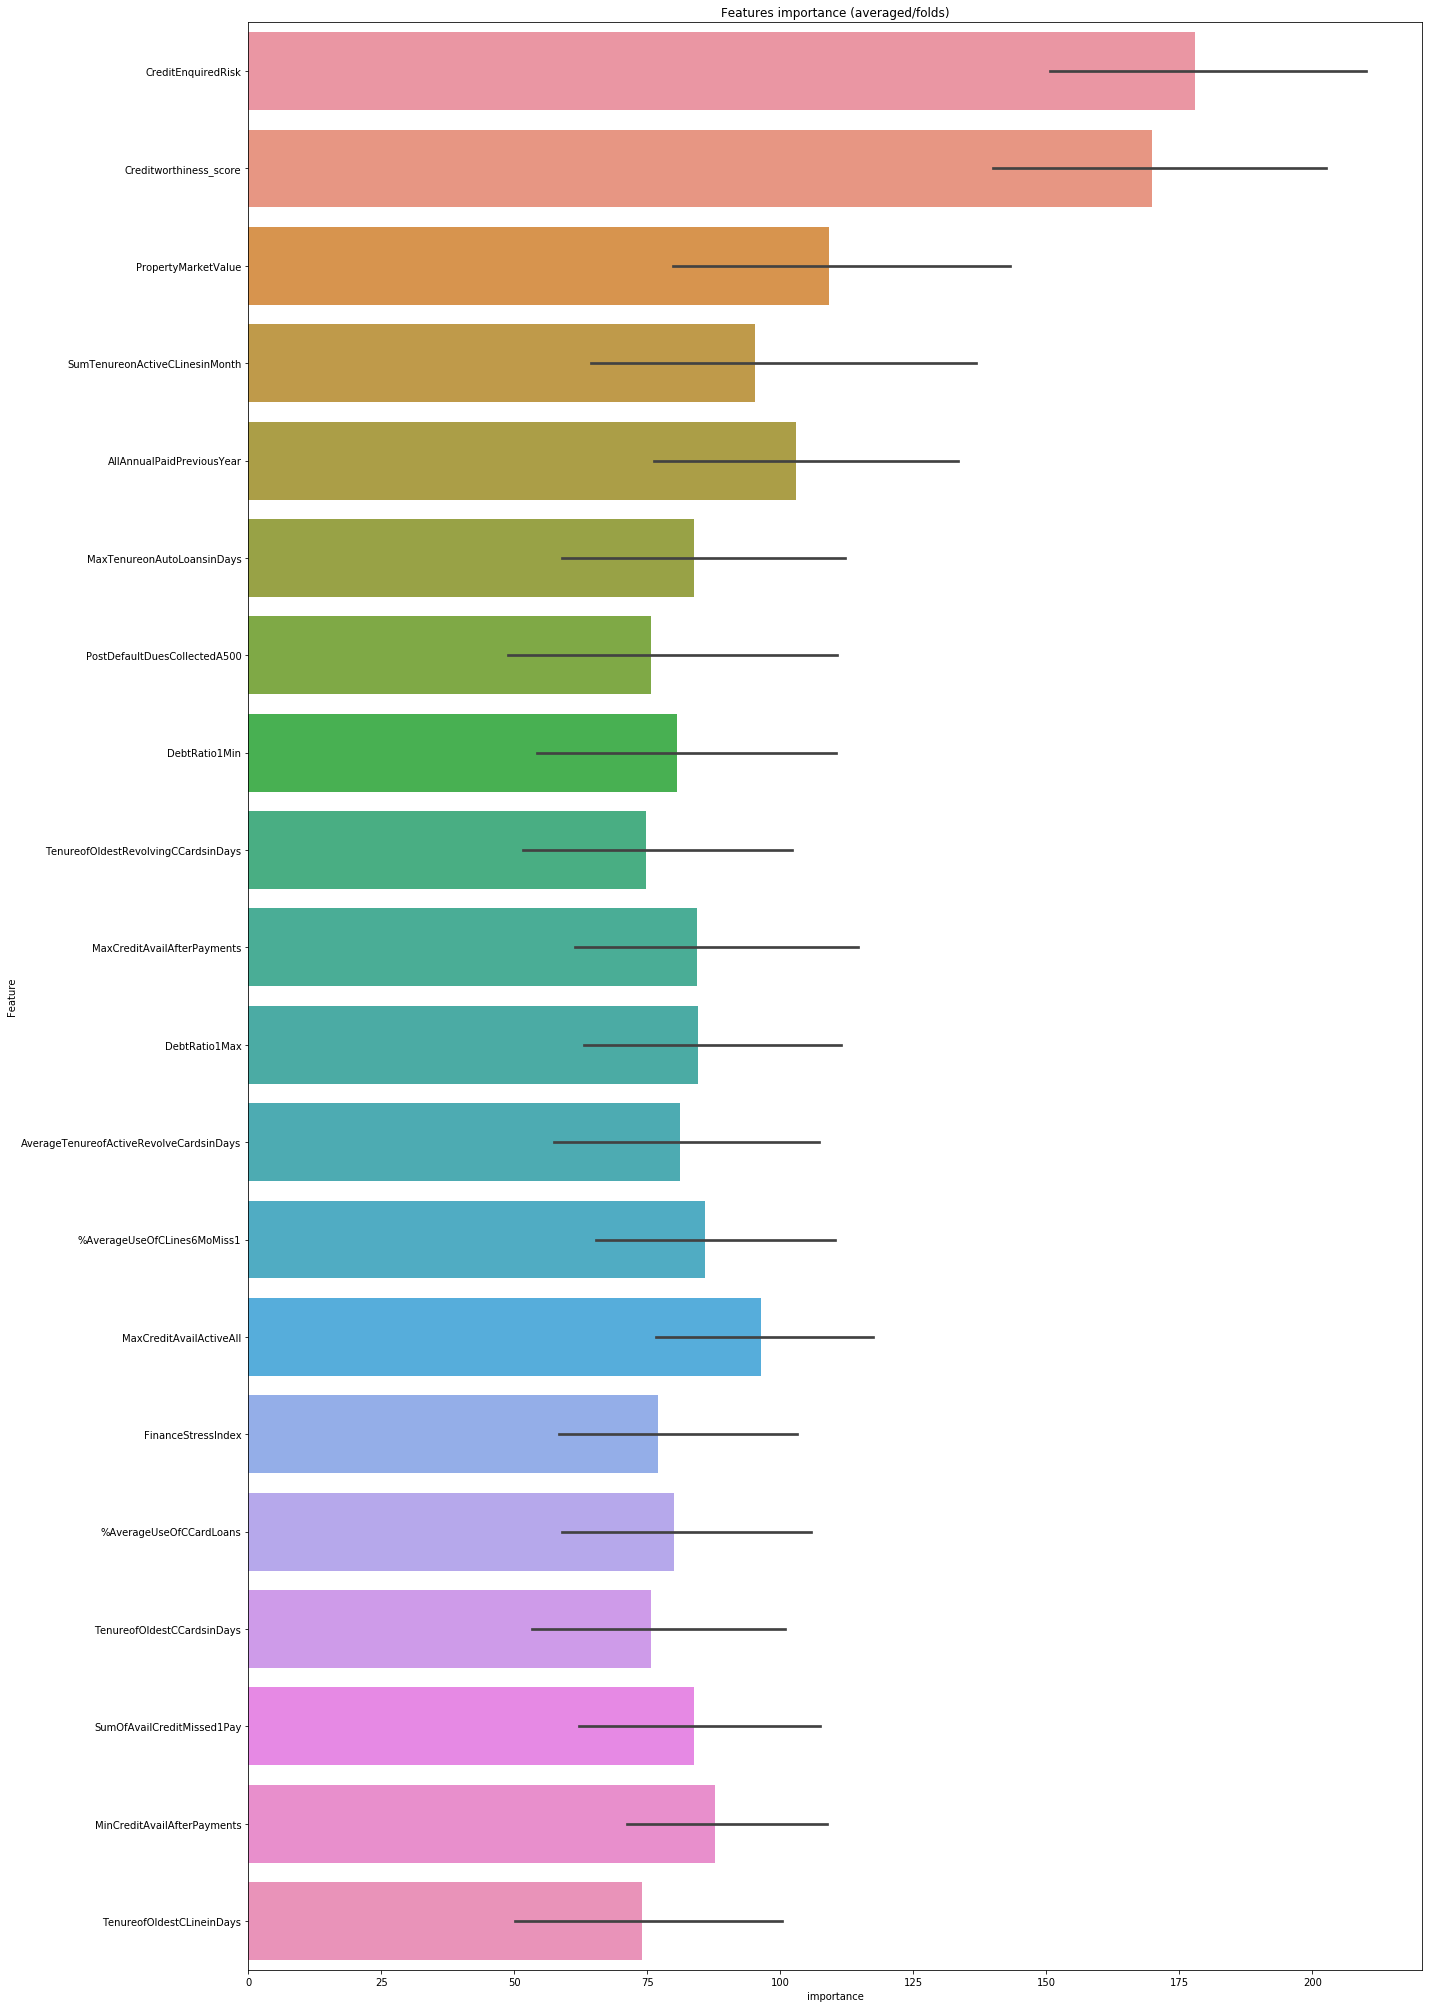

In [43]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(20,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('Feature_Importance.png')

In [35]:
pred

array([0.61850333, 0.63402857, 0.65110051, ..., 0.44275943, 0.75743743,
       0.31161829])

In [24]:
#test_drop.head()

In [25]:
#test_d.head()

In [36]:
submissions = pd.DataFrame()
submissions['Applicant_ID'] = test_drop['Applicant_ID']


In [37]:
submissions['default_status'] = pred


submissions.to_csv('submission_12.csv', index=False, float_format='%.8f')

In [38]:
submissions.head()

,Applicant_ID,default_status
0,Apcnt_1000032,0.618503
1,Apcnt_1000048,0.634029
2,Apcnt_1000052,0.651101
3,Apcnt_1000076,0.888321
4,Apcnt_1000080,0.252068
